# Supervised image classification using TensorFlow

## Setup

In [67]:
# Code (adapted) from https://github.com/ageron/handson-ml

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
import tensorflow as tf

## Transfer Learning for image classification using TensorFlow, Inception v3, and the flowers dataset

In this step we will use a pre-trained Inception v3 model, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for a new classification task: the 5-class flowers dataset (https://www.tensorflow.org/tutorials/image_retraining).

### Fetching the data

In [68]:
# Code (adapted) from https://github.com/ageron/handson-ml

import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")
FLOWERS_PATH = os.path.join("datasets", "flowers")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)
    
fetch_flowers()

Each subdirectory of the flower_photos directory contains all the pictures of a given class. Let's get the list of classes:

In [69]:
# Code (adapted) from https://github.com/ageron/handson-ml

flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Let's get the list of all the image file paths for each class, sort the image paths just to make this notebook behave consistently across multiple runs, and take a peek at a few samples per class.

Class: daisy


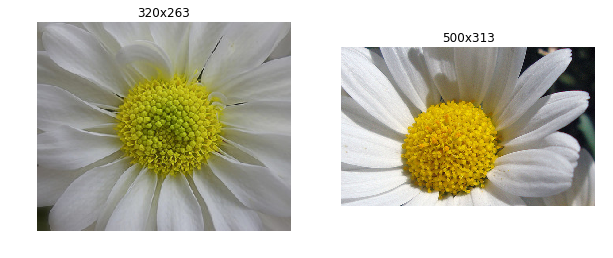

Class: dandelion


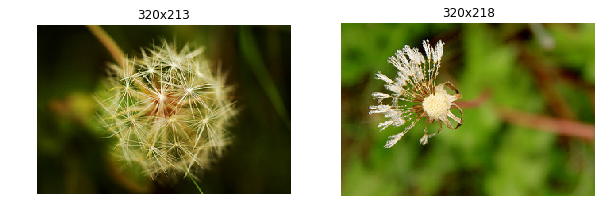

Class: roses


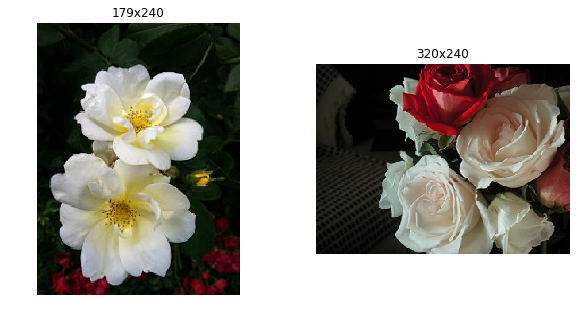

Class: sunflowers


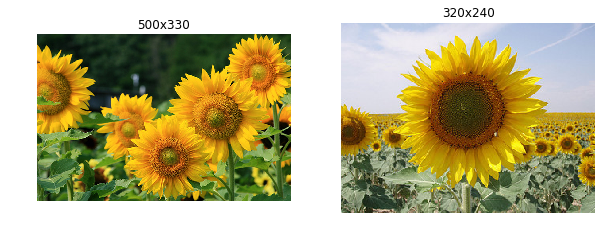

Class: tulips


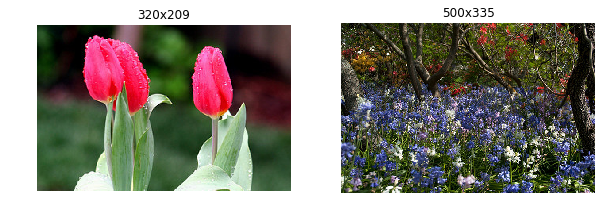

In [70]:
# Code (adapted) from https://github.com/ageron/handson-ml

from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))
            
for paths in image_paths.values():
    paths.sort() 
    
import matplotlib.image as mpimg

n_examples_per_class = 2

width = 299
height = 299
channels = 3

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

### Image preprocessing + data augmentation

In [71]:
# Code (adapted) from https://github.com/ageron/handson-ml

from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255


Let's check out the result on one (random) image:

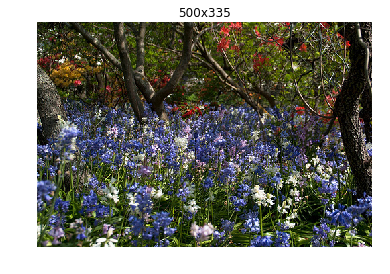

In [72]:
# Code (adapted) from https://github.com/ageron/handson-ml

plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

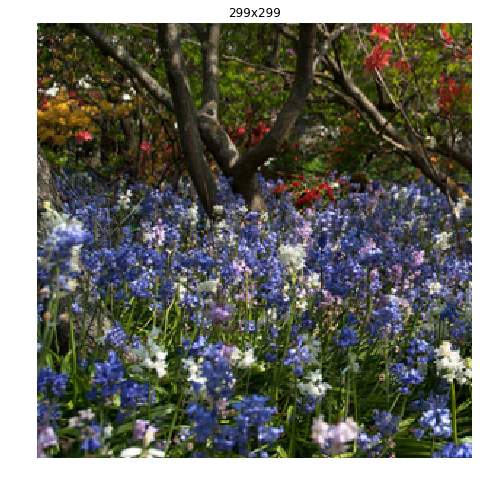

In [73]:
# Code (adapted) from https://github.com/ageron/handson-ml

prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

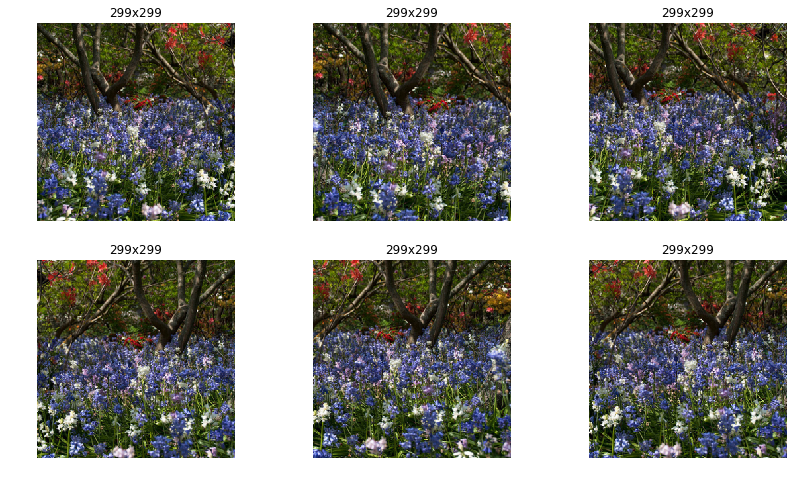

In [74]:
# Code (adapted) from https://github.com/ageron/handson-ml

rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

### Load pre-trained Inception v3

In [75]:
# Code (adapted) from https://github.com/ageron/handson-ml

import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)
    
fetch_pretrained_inception_v3()

import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)
    
class_names = ["background"] + load_class_names()

class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

In [39]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [40]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [41]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the `tf.squeeze()` function:

In [42]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

Then we can add the final fully connected layer on top of this layer:

In [43]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

Finally, we need to add the usual bits and pieces:

* the placeholder for the targets (`y`),
* the loss function, which is the cross-entropy, as usual for a classification task,
* an optimizer, that we use to create a training operation that will minimize the cost function,
* a couple operations to measure the model's accuracy,
* and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's `minimize()` method:

In [44]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

Notice that we created the `inception_saver` before adding the new output layer: we will use this saver to restore the pretrained model state, so we don't want it to try to restore new variables (it would just fail saying it does not know the new variables). The second `saver` will be used to save the final flower model, including both the pretrained variables and the new ones.

### Splitting the dataset

First, we will want to represent the classes as ints rather than strings:

In [45]:
# Code (adapted) from https://github.com/ageron/handson-ml

flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [46]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))
        
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

flower_paths_and_classes_train[:3]

[('datasets/flowers/flower_photos/daisy/19834392829_7d697871f6.jpg', 0),
 ('datasets/flowers/flower_photos/sunflowers/5957007921_62333981d2_n.jpg', 3),
 ('datasets/flowers/flower_photos/tulips/7166635566_ee240b5408_n.jpg', 4)]

This function will be useful to preprocess the test set, and also to create batches during training.

In [47]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch


In [48]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [49]:
X_batch.shape

(4, 299, 299, 3)

In [50]:
X_batch.dtype

dtype('float32')

In [51]:
y_batch.shape

(4,)

In [52]:
y_batch.dtype

dtype('int32')

In [53]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [54]:
X_test.shape

(734, 299, 299, 3)

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

### Train the model

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

In [65]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


Epoch 0.........................................................................  Train accuracy: 0.475
Epoch 1.........................................................................  Train accuracy: 0.75
Epoch 2.........................................................................  Train accuracy: 0.65
Epoch 3.........................................................................  Train accuracy: 0.6
Epoch 4.........................................................................  Train accuracy: 0.775
Epoch 5.........................................................................  Train accuracy: 0.65
Epoch 6.........................................................................  Train accuracy: 0.625
Epoch 7.........................................................................  Train accuracy: 0.65
Epoch 8.........................................................................  Train accuracy: 0.675
Epoch 9...............................................................

### Evaluating the model

In [66]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model


INFO:tensorflow:Restoring parameters from ./my_flowers_model


Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.674417


If you can afford training for 10 epochs, you should reach a ~70% accuracy. 

If you have a GPU, you can try again and let training run for much longer (e.g., using early stopping to decide when to stop). You can also improve the image preprocessing function to make more tweaks to the image (e.g., changing the brightness and hue, rotate the image slightly). You can reach above 95% accuracy on this task. 


# Building model for image classification using TensorFlow

# Pre-Trained MobileNet

## image pre-processing and data augmentation to fit the 224*224 MobileNet

In [2]:
# Code (adapted) from https://github.com/ageron/handson-ml

from scipy.misc import imresize

def prepare_image(image, target_width = 224, target_height = 224, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    #finding the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255


## Loading the pre-trained MobileNet

In [28]:
# Code (adapted) from https://github.com/ageron/handson-ml

import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
MOBILENET_V1_URL = TF_MODELS_URL + "/mobilenet_v1_2018_02_22/mobilenet_v1_1.0_224.tgz"
MOBILENET_PATH = os.path.join("datasets", "mobilenet")
MOBILENET_V1_CHECKPOINT_PATH = os.path.join(MOBILENET_PATH, "mobilenet_v1_1.0_224.ckpt")

def fetch_pretrained_mobilenet_v1(url=MOBILENET_V1_URL, path=MOBILENET_PATH):
    if os.path.exists(MOBILENET_V1_CHECKPOINT_PATH):
        return
    os.makedirs(path) #removed exist_ok=True parameter
    tgz_path = os.path.join(path, "mobilenet_v1_1.0_224.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    mobilenet_tgz = tarfile.open(tgz_path)
    mobilenet_tgz.extractall(path=path)
    mobilenet_tgz.close()
    os.remove(tgz_path)
    
fetch_pretrained_mobilenet_v1()

import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)
    
class_names = ["background"] + load_class_names()

class_names[:5]

Downloading: 100%

['background',
 'tench, Tinca tinca\r',
 'goldfish, Carassius auratus\r',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias\r',
 'tiger shark, Galeocerdo cuvieri\r']

In [28]:
import tensorflow.contrib.slim as slim
from models.research.slim.nets import mobilenet_v1

reset_graph()
tf.logging.set_verbosity(tf.logging.INFO)
X = tf.placeholder(tf.float32, shape=[None, 224, 224, 3], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(mobilenet_v1.mobilenet_v1_arg_scope()):
    logits, end_points = mobilenet_v1.mobilenet_v1(X, num_classes=1001, is_training=False)    

mobilenet_saver = tf.train.Saver()

In [29]:
#displaying all the layers
end_points

{'AvgPool_1a': <tf.Tensor 'MobilenetV1/Logits/AvgPool_1a/AvgPool:0' shape=(?, 1, 1, 1024) dtype=float32>,
 'Conv2d_0': <tf.Tensor 'MobilenetV1/MobilenetV1/Conv2d_0/Relu6:0' shape=(?, 112, 112, 32) dtype=float32>,
 'Conv2d_10_depthwise': <tf.Tensor 'MobilenetV1/MobilenetV1/Conv2d_10_depthwise/Relu6:0' shape=(?, 14, 14, 512) dtype=float32>,
 'Conv2d_10_pointwise': <tf.Tensor 'MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Relu6:0' shape=(?, 14, 14, 512) dtype=float32>,
 'Conv2d_11_depthwise': <tf.Tensor 'MobilenetV1/MobilenetV1/Conv2d_11_depthwise/Relu6:0' shape=(?, 14, 14, 512) dtype=float32>,
 'Conv2d_11_pointwise': <tf.Tensor 'MobilenetV1/MobilenetV1/Conv2d_11_pointwise/Relu6:0' shape=(?, 14, 14, 512) dtype=float32>,
 'Conv2d_12_depthwise': <tf.Tensor 'MobilenetV1/MobilenetV1/Conv2d_12_depthwise/Relu6:0' shape=(?, 7, 7, 512) dtype=float32>,
 'Conv2d_12_pointwise': <tf.Tensor 'MobilenetV1/MobilenetV1/Conv2d_12_pointwise/Relu6:0' shape=(?, 7, 7, 1024) dtype=float32>,
 'Conv2d_13_depthwise'

In [30]:
#setting prelogits to the pre-softmax layer
prelogits=end_points["Logits"]
prelogits.shape

TensorShape([Dimension(None), Dimension(1001)])

In [31]:
#Then we can add the final fully connected layer on top of this layer:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

In [32]:
#since we want to train only the output layer (all other layers must be frozen),
#    we must pass the list of variables to train to the optimizer's minimize() method:

#placeholder for the targets (y)
y = tf.placeholder(tf.int32, shape=[None])

#loss function, which is the cross-entropy, as usual for a classification task
#optimizer, that we use to create a training operation that will minimize the cost function
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

#couple operations to measure the model's accuracy
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

#initializer and a saver
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

In [33]:
# Code (adapted) from https://github.com/ageron/handson-ml

#representing the classes as ints rather than strings:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [34]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))
        
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

flower_paths_and_classes_train[:3]

[('datasets\\flowers\\flower_photos\\daisy\\19834392829_7d697871f6.jpg', 0),
 ('datasets\\flowers\\flower_photos\\sunflowers\\5957007921_62333981d2_n.jpg',
  3),
 ('datasets\\flowers\\flower_photos\\tulips\\7166635566_ee240b5408_n.jpg', 4)]

In [45]:
#preprocess the test set, and also to create batches during training.
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)
print("X_batch shape:", X_batch.shape, "dtype:", X_batch.dtype)
print("y_batch shape:", y_batch.shape, "dtype:", y_batch.dtype)
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))
print("X_test shape:", X_test.shape)

X_batch shape: (4, 224, 224, 3) dtype: float32
y_batch shape: (4,) dtype: int32
X_test shape: (734, 224, 224, 3)


In [42]:
#train the network (or more precisely, the output layer we just added, since all the other layers are frozen)
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    mobilenet_saver.restore(sess, MOBILENET_V1_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from datasets\mobilenet\mobilenet_v1_1.0_224.ckpt
Epoch 0.........................................................................  Train accuracy: 0.9
Epoch 1.........................................................................  Train accuracy: 0.925
Epoch 2.........................................................................  Train accuracy: 0.9
Epoch 3.........................................................................  Train accuracy: 0.875
Epoch 4.........................................................................  Train accuracy: 0.875
Epoch 5.........................................................................  Train accuracy: 0.925
Epoch 6.........................................................................  Train accuracy: 0.875
Epoch 7.........................................................................  Train accuracy: 0.95
Epoch 8.........................................................................  Trai

In [43]:
#evaluate the model
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.892336
